# Decision Tree from Scratch - Demo

This notebook demonstrates the decision tree implementation built from scratch.
We'll train models on the insurance dataset (regression) and visualize the results.

**Key Learning Goals:**
1. Understand how decision trees split data
2. See how ensemble methods (Random Forest, Gradient Boosting) improve on single trees
3. Visualize tree structure to interpret the model

## Setup

First, we import our from-scratch implementations and set up the environment.

In [132]:
# Standard imports
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
import sys, importlib, pkgutil

# Add project root to path so we can import src modules
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

def reload_package(pkg_name: str):
	"""Fully unload a package and all submodules, then import fresh."""
	importlib.invalidate_caches()
	# Collect all loaded submodules first (before deleting)
	to_delete = [m for m in list(sys.modules) if m == pkg_name or m.startswith(pkg_name + ".")]
	# Delete them so Python must import from disk again
	for m in to_delete:
		del sys.modules[m]
	# Re-import the root package and all submodules~
	pkg = importlib.import_module(pkg_name)
	for _, name, _ in pkgutil.walk_packages(pkg.__path__, pkg.__name__ + "."):
		importlib.import_module(name)
reload_package("src")

# Import our from-scratch implementations
from src.decision_tree import DecisionTree
from src.random_forest import RandomForest
from src.gradient_boosting import GradientBoosting
from src.decision_tree_graph import DecisionTreeVisualizer
from src.data_utils import load_insurance_data

# Pandas display settings
pd.set_option('display.max_columns', 20)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Graphviz setup (adjust path for your system)
# Windows: graphviz_bin = r"C:\Program Files\Graphviz\bin"
# Mac/Linux: Usually works without this
if os.name == 'nt':  # Windows
    graphviz_bin = r"C:\Program Files\Graphviz\bin"
    os.environ["PATH"] = graphviz_bin + ";" + os.environ.get("PATH", "")

print("Setup complete!")

Setup complete!


## Load Data

We use the Healthcare Insurance dataset, which is a **regression** problem.

**Features:**
- `age`: Patient age
- `sex`: Gender (male/female)
- `bmi`: Body mass index
- `children`: Number of children
- `smoker`: Smoking status (yes/no)
- `region`: US region

**Target:**
- `charges`: Medical insurance charges (what we want to predict)

In [133]:
# Load and split the insurance dataset
# This will download from Kaggle if not already present
X_train, X_test, y_train, y_test = load_insurance_data()

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nFeatures: {list(X_train.columns)}")
print(f"Target: {y_train.columns[0]}")

Training set: 1070 samples, 6 features
Test set: 268 samples

Features: ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
Target: charges


In [134]:
# Preview the data
X_train.head()

,age,sex,bmi,children,smoker,region
764,45,female,25.18,2,no,northeast
887,36,female,30.02,0,no,northwest
890,64,female,26.89,0,yes,northwest
1293,46,male,25.75,3,no,northwest
259,19,male,31.92,0,yes,northwest


## 1. Single Decision Tree

Let's start with a single decision tree. Key parameters:
- `max_depth=3`: Shallow tree for interpretability (prevents overfitting)
- `criterion='variance'`: Use variance reduction for regression
- `min_samples_split=10`: Need at least 10 samples to split a node

In [135]:
# Create and train a single decision tree
tree = DecisionTree(
    criterion='variance',
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=2,
)

# Train the model
model = tree.train(X_train, y_train)

# Make predictions
y_pred = tree.predict(model, X_test)

# Evaluate
mae = np.mean(np.abs(y_test.values.ravel() - y_pred))
print(f"Mean Absolute Error: ${mae:,.2f}")
print(f"Total nodes in tree: {tree.node_count}")

Mean Absolute Error: $9,588.98
Total nodes in tree: 15


C:\Users\josep\software\git\decisions-decisions\src\decision_tree_graph.py:204: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


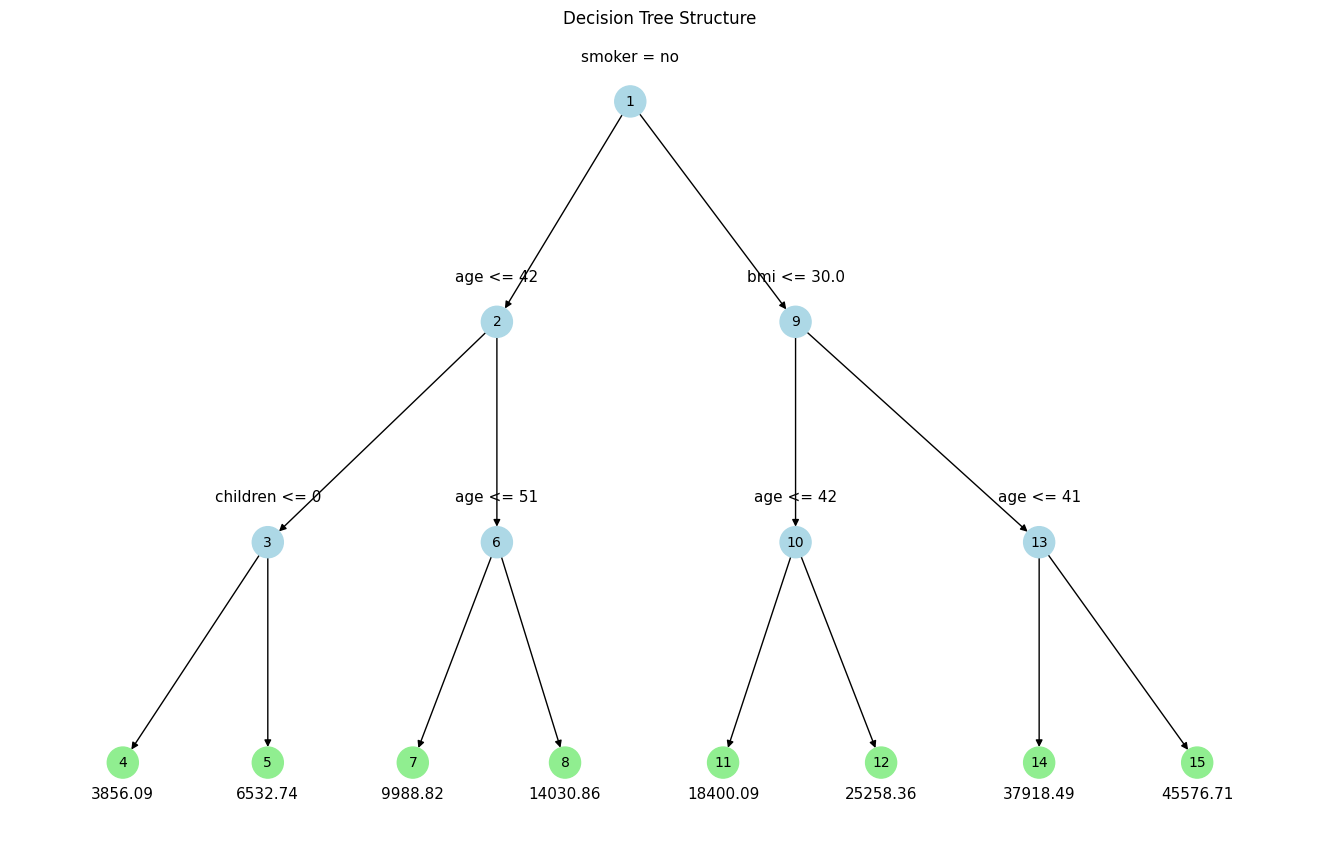

In [136]:
# Visualize the tree structure
# This shows HOW the tree makes decisions
viz = DecisionTreeVisualizer()
viz.visualize(model, feature_dtypes=X_train.dtypes)

### Interpreting the Tree

Reading the visualization:
- **Blue nodes**: Decision points ("if feature <= value, go left")
- **Green nodes**: Leaf nodes (prediction values)
- The tree learns that `smoker` is the most important split!
- Notice how smokers tend to have much higher predicted charges

## 2. Random Forest

Random Forest builds multiple trees on **bootstrap samples** (sampling with replacement)
and averages their predictions. This reduces overfitting.

Key insight: Each tree sees different data, so they make different errors.
When averaged, the random errors cancel out!

In [137]:
# Create and train a Random Forest
rf = RandomForest(
    n_estimators=10,  # 10 trees
    criterion='variance',
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=2,
    verbose=True,  # Show progress
)

rf_model = rf.train(X_train, y_train)

Training tree 1/10
Training tree 2/10
Training tree 3/10
Training tree 4/10
Training tree 5/10
Training tree 6/10
Training tree 7/10
Training tree 8/10
Training tree 9/10
Training tree 10/10


In [138]:
# Evaluate Random Forest
y_pred_rf = rf.predict(rf_model, X_test)

mae_rf = np.mean(np.abs(y_test.values.ravel() - y_pred_rf))
print(f"Random Forest MAE: ${mae_rf:,.2f}")
print(f"Single Tree MAE: ${mae:,.2f}")
print(f"\nImprovement: ${mae - mae_rf:,.2f} ({(mae - mae_rf)/mae*100:.1f}%)")

Random Forest MAE: $9,004.04
Single Tree MAE: $9,588.98

Improvement: $584.94 (6.1%)


## 3. Gradient Boosting

Gradient Boosting builds trees **sequentially**, where each tree corrects
the errors of the previous ensemble.

How it works:
1. Start with mean prediction
2. Compute residuals (errors)
3. Train a tree to predict residuals
4. Add scaled tree to ensemble
5. Repeat

The `learning_rate` controls how much each tree contributes (smaller = more regularization).

In [140]:
# Create and train Gradient Boosting
gb = GradientBoosting(
    n_estimators=50,     # 50 boosting rounds
    learning_rate=0.1,   # Shrinkage factor
    criterion='squared_error',
    max_depth=3,         # Shallow trees work well for boosting
    min_samples_split=10,
    min_samples_leaf=2,
    verbose=True,
)

gb_model = gb.train(X_train, y_train)

Boosting round 1/50
Boosting round 2/50
Boosting round 3/50
Boosting round 4/50
Boosting round 5/50
Boosting round 6/50
Boosting round 7/50
Boosting round 8/50
Boosting round 9/50
Boosting round 10/50
Boosting round 11/50
Boosting round 12/50
Boosting round 13/50
Boosting round 14/50
Boosting round 15/50
Boosting round 16/50
Boosting round 17/50
Boosting round 18/50
Boosting round 19/50
Boosting round 20/50
Boosting round 21/50
Boosting round 22/50
Boosting round 23/50
Boosting round 24/50
Boosting round 25/50
Boosting round 26/50
Boosting round 27/50
Boosting round 28/50
Boosting round 29/50
Boosting round 30/50
Boosting round 31/50
Boosting round 32/50
Boosting round 33/50
Boosting round 34/50
Boosting round 35/50
Boosting round 36/50
Boosting round 37/50
Boosting round 38/50
Boosting round 39/50
Boosting round 40/50
Boosting round 41/50
Boosting round 42/50
Boosting round 43/50
Boosting round 44/50
Boosting round 45/50
Boosting round 46/50
Boosting round 47/50
Boosting round 48/50
B

In [141]:
# Evaluate Gradient Boosting
y_pred_gb = gb.predict(gb_model, X_test)

mae_gb = np.mean(np.abs(y_test.values.ravel() - y_pred_gb))
print(f"Gradient Boosting MAE: ${mae_gb:,.2f}")
print(f"Random Forest MAE: ${mae_rf:,.2f}")
print(f"Single Tree MAE: ${mae:,.2f}")

Gradient Boosting MAE: $9,561.42
Random Forest MAE: $9,004.04
Single Tree MAE: $9,588.98


## Summary

We implemented and compared three tree-based methods:

| Method | Description | Strengths |
|--------|-------------|------------|
| **Decision Tree** | Single tree | Interpretable, fast |
| **Random Forest** | Parallel ensemble of trees | Reduces variance, robust |
| **Gradient Boosting** | Sequential ensemble | Often best accuracy |

### Key Takeaways

1. **Single trees** are great for understanding - we can see exactly what splits matter
2. **Random Forests** improve accuracy by averaging diverse trees
3. **Gradient Boosting** improves by iteratively correcting errors
4. All of this was implemented **from scratch** - no sklearn!

### What's Next?

- Try different hyperparameters (max_depth, n_estimators, learning_rate)
- Test on the mobile phone classification dataset
- Read the source code to understand the algorithms deeply